In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import datetime as dt

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

import plotly.express as px
import folium 
import folium.plugins
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import itertools
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import warnings
warnings.filterwarnings("ignore")

from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, inferno,Set1
from datashader import transfer_functions as tf
output_notebook()

Loading BokehJS ...

In [7]:
# data loading and cleaning
dt1 = pd.read_csv('data/trip_data/trip_data_3.csv', nrows=1000000)
dt1.drop(columns=' store_and_fwd_flag', inplace=True)
# dt2 = pd.read_csv('data/trip_data/trip_data_2.csv')

df1 = pd.read_csv('data/trip_fare/trip_fare_3.csv', nrows=1000000)
# df2 = pd.read_csv('data/trip_fare/trip_fare_2.csv')
df = pd.merge(dt1, df1, how='left', on=['medallion', ' hack_license', ' vendor_id', ' pickup_datetime'])
for i in df.columns:
    df.rename(columns={i : i.strip(' ')}, inplace=True)
df['trip_time'] = df['trip_time_in_secs']/60
coord = ['pickup_longitude','pickup_latitude', 
         'dropoff_longitude', 'dropoff_latitude']

for i in coord :
    df[i] = df[i].replace(0,np.nan)
df.dropna(inplace=True)
# drop observations less than 0 and  greater than 99.9% percentile value.
df = df[(df["fare_amount"] > 0) & (
    df["fare_amount"] < df["fare_amount"].quantile(.999))]

df = df[(df["trip_distance"] > 0) & (
    df["trip_distance"] < df["trip_distance"].quantile(.9999))]

df = df[(df["trip_time_in_secs"] > 0) & (
    df["trip_time_in_secs"] < df["trip_time_in_secs"].quantile(.9999))]

for i in coord:
    df = df[(df[i] > df[i].quantile(.001)) &
            (df[i] < df[i].quantile(.999))]
    
    
pickupTime = pd.to_datetime(df['pickup_datetime'])

df['src hourOfDay'] = (pickupTime.dt.hour*60.0 + pickupTime.dt.minute)   / 60.0
df['dst hourOfDay'] = df['src hourOfDay'] + df['trip_time'] / 60.0

df['dayOfWeek']     = pickupTime.dt.weekday
df['hourOfWeek']    = df['dayOfWeek']*24.0 + df['src hourOfDay']

allLat  = np.array(list(df['pickup_latitude'])  + list(df['dropoff_latitude']))
allLong = np.array(list(df['pickup_longitude']) + list(df['dropoff_longitude']))

medianLat  = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier  = 111.32
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

df['src lat']   = latMultiplier  * (df['pickup_latitude']   - medianLat)
df['src long']  = longMultiplier * (df['pickup_longitude']  - medianLong)
df['dst lat']   = latMultiplier  * (df['dropoff_latitude']  - medianLat)
df['dst long']  = longMultiplier * (df['dropoff_longitude'] - medianLong)
df = df.reset_index(drop=True)

allLat  = np.array(list(df['src lat'])  + list(df['dst lat']))
allLong = np.array(list(df['src long']) + list(df['dst long']))



In [8]:
#plot datapoints by location coordinates
def plot_data_points(longitude,latitude,data_frame,focus_point):
    
    #plot dimensions
#     x_range, y_range = ((-74.14,-73.73), (40.6,40.9))
#     plot_width  = int(750)
#     plot_height = int(plot_width//1.2)
    export  = partial(export_image, export_path="export", background="black")
    fig = figure(background_fill_color = "black")    
    #plot data points
    cvs = ds.Canvas()
    agg = cvs.points(data_frame,longitude,latitude,
                      ds.count(focus_point))
    img = tf.shade(agg, cmap= Hot, how='eq_hist')
    image_xpt  =  tf.dynspread(img, threshold=0.5, max_px=4)
    
    return export(image_xpt,"Data")

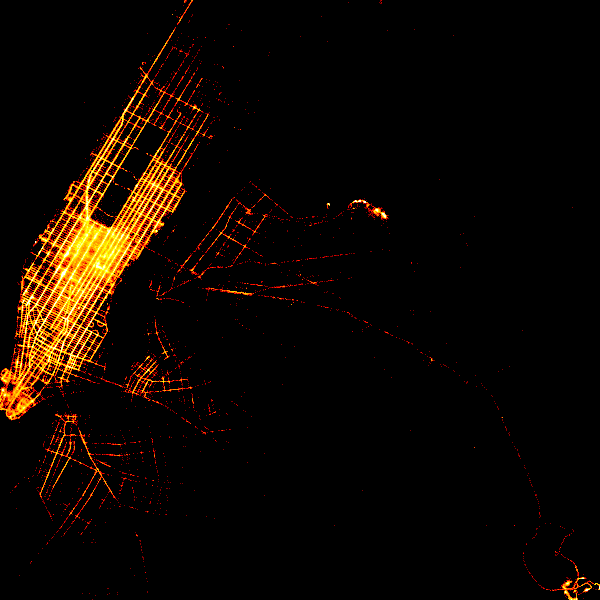

In [9]:
plot_data_points('pickup_longitude', 'pickup_latitude',df,"passenger_count")

The majority of the trips are originating from the city 
The other bright spots are airpots. We can add flights data later

Below, more people take taxis to travel to the suburbs. But why the south is it that cheap? Maybe add population data in a neighbourhood later

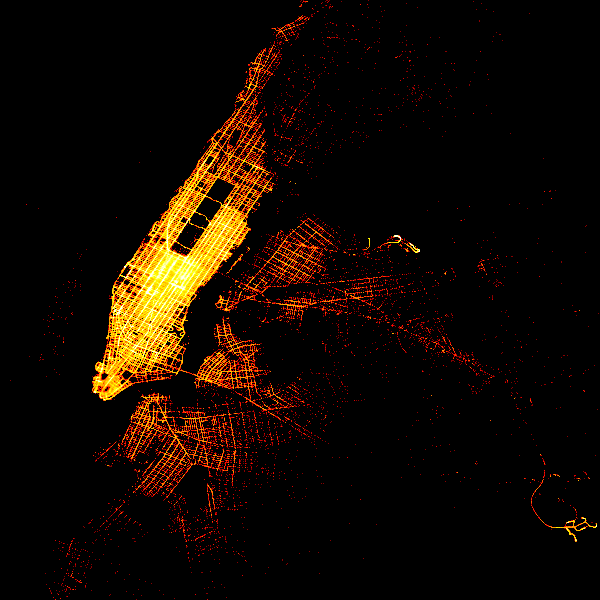

In [11]:
plot_data_points('dropoff_longitude', 'dropoff_latitude',df,"passenger_count")